In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance


# Segmentation
Credits: https://github.com/leparrav/Playground/tree/master/StackOverFlow/Leaf

In [3]:
def increase_contrast(img_path):
    #read the image
    im = Image.open(img_path)
    #image brightness enhancer
    enhancer = ImageEnhance.Contrast(im)
    #increase contrast
    factor = 10 
    im_output = enhancer.enhance(factor)
    return im_output

In [23]:
def get_edge_segmentation(img_path, bilateral = True, resize = False, crop = False, white_bg = False):
    # read img
    img = cv2.imread(img_path)
    # convert to rgb
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # resize
    img_resized = img_rgb.copy()
    if resize:
        img_resized = cv2.resize(img_rgb, (250,250))
    # apply bilateral filter
    img_filtered = img_resized.copy()
    if bilateral:
        img_filtered = cv2.bilateralFilter(img_resized,45,200,40, cv2.BORDER_REFLECT)
        plt.imshow(img_filtered)
        plt.show()
    # extract edges
    canny = cv2.Canny(img_filtered, 100,  150) 
    plt.imshow(canny, cmap='gray')#
    plt.show()#
    # find contours from edges
    contours, _ = cv2.findContours(canny, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    if len(contours) > 10:
        contours = contours[:10]
    # draw contours on the image
    new_image = img_resized.copy()
    cv2.drawContours(new_image, contours, -1, (255, 0, 0), 2)
    plt.imshow(new_image)#
    plt.show()#
    # Get convex hull for max contours and draw them
    unified=[]
    conts = np.vstack(contours)
    hull = cv2.convexHull(conts)
    unified.append(hull)
    cv2.drawContours(new_image,unified,-1,(0,0,255),3)
    plt.imshow(new_image)#
    plt.show()#
    # First create our rectangle that contains the object
    x_min = min(hull[:, 0, 0])
    x_max = max(hull[:, 0, 0])
    y_min = min(hull[:, 0, 1])
    y_max = max(hull[:, 0, 1])
    width = x_max - x_min
    height = y_max - y_min
    rect = (x_min,y_min,width,height)
    # create mask
    mask = np.zeros(img_resized.shape[:2],np.uint8)
    # set values for grabCut
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    # segmentation
    cv2.grabCut(img_resized,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    plt.imshow(mask)#
    plt.show()
    mask2 = np.where(((mask==cv2.GC_PR_BGD)|(mask==cv2.GC_BGD)),0,1).astype('uint8')
    img = img_resized*mask2[:,:,np.newaxis]
    # prepare mask
    mask2 = cv2.cvtColor(mask2*255, cv2.COLOR_GRAY2BGR)
    # crop image with the region of interest
    if crop:
        img = img[y_min:y_max, x_min:x_max]
        mask2 = mask2[y_min:y_max, x_min:x_max]
    # invert background color
    if white_bg:
        img = img + (255 - mask2)
    return img, mask2

    

## Try segmentation

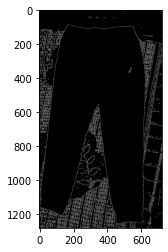

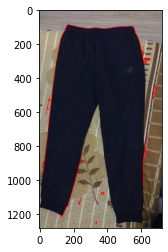

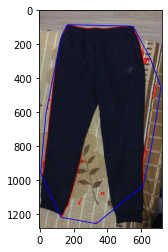

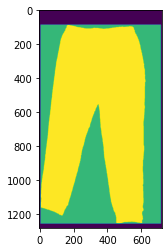

In [24]:
img, mask = get_edge_segmentation('../test_imgs/gabri_2.jpg', bilateral=False, crop = True, white_bg=True)

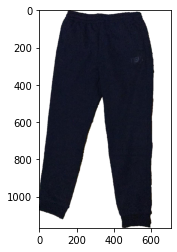

In [25]:
plt.imshow(img)
plt.show()

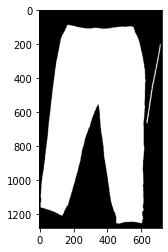

In [7]:
plt.imshow(mask, cmap='gray')


In [6]:
cv2.imwrite('../test_imgs/shoe_mask.bmp', mask*255)

True